### 500224491 - Vishruti Avlani
### Model-3 VAE(Variable Auto Encoder)

### Importing library

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.stats import entropy
from numpy import cov, trace, iscomplexobj
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

2024-07-25 04:37:27.455065: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 04:37:27.455195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 04:37:27.592825: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
dataset_folder_path = '/kaggle/input/expressions/dataset'
csv_path = '/kaggle/input/expressions/data.csv'

dat = pd.read_csv(csv_path)

### Pre-processing

In [6]:
def preprocess_image(image_path):

    image = cv2.imread(image_path)

    image = cv2.resize(image, (299, 299))
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    
    for i in range(3):
        image[:, :, i] = cv2.equalizeHist(image[:, :, i])
        image[:, :, i] = cv2.GaussianBlur(image[:, :, i], (5, 5), 0)
    
    normalized_image = image / 255.0
    
    return normalized_image

In [7]:
images = []
labels = []

max_images_per_class = 500
cls_cnt = {class_name: 0 for class_name in dat['label'].unique()}

for idx, row in dat.iterrows():
    label = row['label']
    if cls_cnt[label] < max_images_per_class:
        image_path = os.path.join(dataset_folder_path, row['path'])
        if os.path.exists(image_path):
            preprocessed_image = preprocess_image(image_path)
            images.append(preprocessed_image)
            labels.append(label)
            cls_cnt[label] += 1

images = np.array(images)
labels = np.array(labels)

In [8]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(images)

In [9]:
from tensorflow.keras.layers import Layer

class VAELoss(Layer):
    def __init__(self, **kwargs):
        super(VAELoss, self).__init__(**kwargs)

    def call(self, inputs):
        x, z_mean, z_log_var, outputs = inputs
        
        recnst_loss = tf.keras.losses.binary_crossentropy(x, outputs)
        recnst_loss = tf.reduce_sum(recnst_loss, axis=[1, 2]) 
        
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        
        vae_loss = K.mean(recnst_loss + kl_loss)
        self.add_loss(vae_loss)
        
        return outputs

    def compute_output(self, input_shape):
        return input_shape[0]


In [10]:
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.models import Model


def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Encoder

In [11]:
inp_shape = (299, 299, 3) 
latent_dim = 2

inputs = layers.Input(shape=inp_shape)
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2D(256, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 75,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 38, 38,    │     73,856 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 19, 19,    │    295,168 │ conv2d_2[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 92416)     │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 23,658,752 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        514 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        514 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 2)         │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,048,196 (91.74 MB)

 Trainable params: 24,048,196 (91.74 MB)

 Non-trainable params: 0 (0.00 B)

### Decoder

In [12]:
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(256, activation='relu')(latent_inputs)
x = layers.Dense(19 * 19 * 256, activation='relu')(x)
x = layers.Reshape((19, 19, 256))(x)
x = layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(3, 4, activation='sigmoid', strides=2, padding='valid')(x)  
x = layers.Conv2DTranspose(3, 3, activation='sigmoid', strides=1, padding='valid')(x)  
x = layers.Cropping2D(((157, 156), (157, 156)))(x) 

decoder = Model(latent_inputs, x, name='decoder')
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 92416)          │    23,750,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 19, 19, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 38, 38, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 76, 76, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 152, 152, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 304, 304, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 610, 610, 3)    │         1,539 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 612, 612, 3)    │            84 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d (Cropping2D)         │ (None, 299, 299, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,730,679 (94.34 MB)

 Trainable params: 24,730,679 (94.34 MB)

 Non-trainable params: 0 (0.00 B)

### VAE

In [13]:
z_mean, z_log_var, z = encoder(inputs)
outputs = decoder(z)
vae_outputs = VAELoss()([inputs, z_mean, z_log_var, outputs])
vae = Model(inputs, vae_outputs, name='vae')

vae.compile(optimizer='adam')
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 2),       │ 24,048,196 │ input_layer[0][0] │
│ (Functional)        │ (None, 2), (None, │            │                   │
│                     │ 2)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 299, 299,  │ 24,730,679 │ encoder[0][2]     │
│ (Functional)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss (VAELoss)  │ (None, 299, 299,  │          0 │ input_layer[0][0… │
│                     │ 3)                │            │ encoder[0][0],    │
│                     │                   │            │ encoder[0][1],    │
│                     │                   │            │ decoder[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,778,875 (186.08 MB)

 Trainable params: 48,778,875 (186.08 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training

Epoch 1/11


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/93 ━━━━━━━━━━━━━━━━━━━━ 47:32 31s/step - loss: 65277.1094

I0000 00:00:1721882856.830045     106 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/stepep - loss: 62842.63


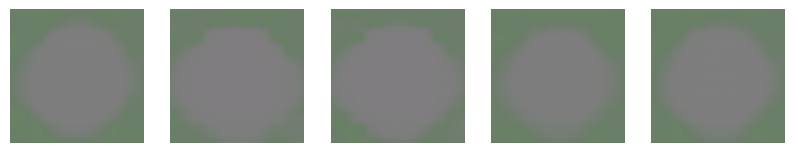

93/93 ━━━━━━━━━━━━━━━━━━━━ 101s 762ms/step - loss: 62835.3477
Epoch 2/11
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 145us/step - loss: 61420.9883 
Epoch 3/11


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


93/93 ━━━━━━━━━━━━━━━━━━━━ 59s 583ms/step - loss: 61241.8594
Epoch 4/11
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 70us/step - loss: 60118.8906  
Epoch 5/11
93/93 ━━━━━━━━━━━━━━━━━━━━ 59s 585ms/step - loss: 59877.8867
Epoch 6/11
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - loss: 59288.2266  
Epoch 7/11
93/93 ━━━━━━━━━━━━━━━━━━━━ 58s 578ms/step - loss: 58706.4844
Epoch 8/11
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 67us/step - loss: 58322.8906  
Epoch 9/11
93/93 ━━━━━━━━━━━━━━━━━━━━ 59s 588ms/step - loss: 58271.2461
Epoch 10/11
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 99us/step - loss: 57225.2148  
Epoch 11/11
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/steptep - loss: 58018.972


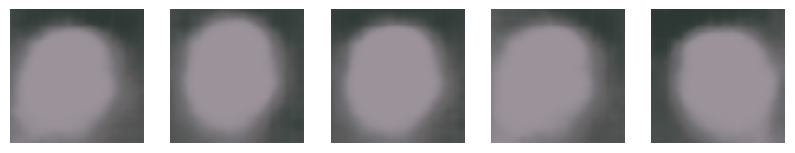

93/93 ━━━━━━━━━━━━━━━━━━━━ 60s 594ms/step - loss: 58018.0117


In [14]:
batch_size = 32
epochs = 11

train_gen = datagen.flow(images, batch_size=batch_size)

class DisplayGeneratedImg(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            num_samples = 5  
            latent_samples = np.random.normal(size=(num_samples, latent_dim))
            generated_images = decoder.predict(latent_samples)
            generated_images = np.clip(generated_images * 255.0, 0, 255).astype('uint8')

            plt.figure(figsize=(10, 2))
            for i in range(num_samples):
                plt.subplot(1, num_samples, i + 1)
                plt.imshow(generated_images[i])  
                plt.axis('off')
            plt.show()

vae.fit(train_gen, epochs=epochs, steps_per_epoch=len(images) // batch_size, callbacks=[DisplayGeneratedImg()])
